<a href="https://colab.research.google.com/github/olfabre/amsProjetMaster1/blob/olivier/Generation_prenoms_V8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Appareil utilisé : cuda:0
Nombre de prénoms : 9408
Ensemble d'entraînement : 6585, Validation : 1881, Test : 942
Démarrage de l'entraînement...

-----------
|  ENTRAÎNEMENT  |
-----------


Époch 1 : La perte de validation a diminué à 4.0201. Modèle sauvegardé.
Précision validation : 0.0000

Prénoms générés :
- Aee
- Be
- C
- De
- Eee
0m 0.05s Époch 1/1000, Perte entraînement : 4.0779, Précision entraînement : 0.0000
Perte validation : 4.0201, Précision validation : 0.0000


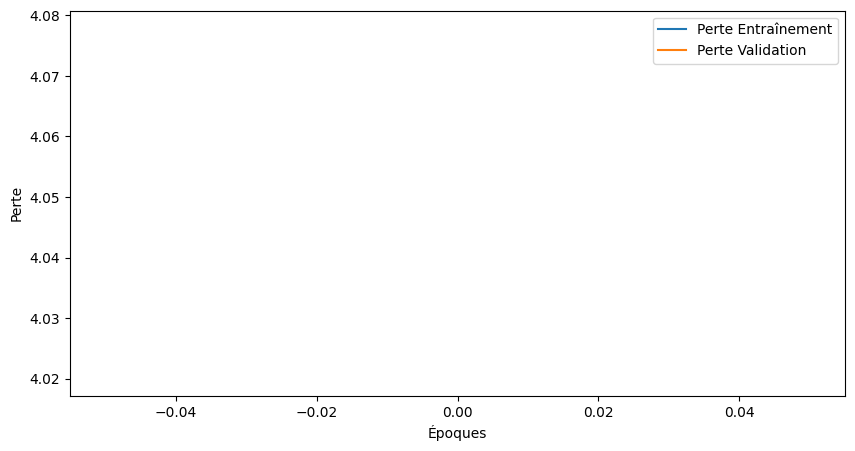

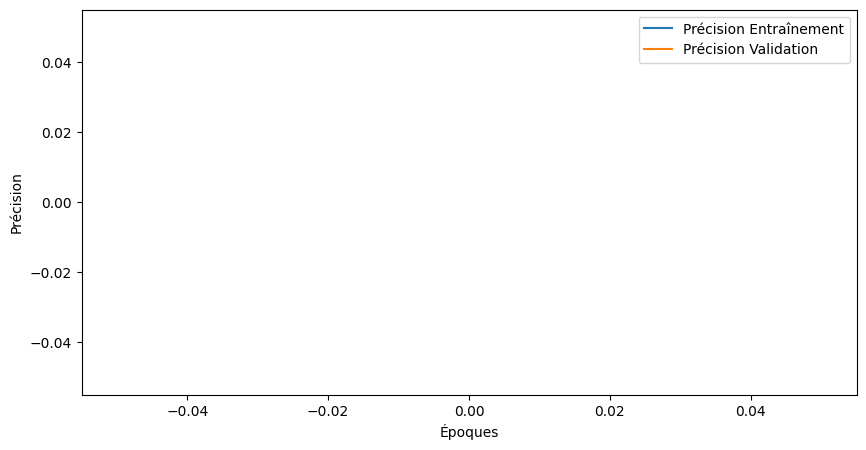


Époch 2 : La perte de validation a diminué à 3.8515. Modèle sauvegardé.
Précision validation : 0.1429

Prénoms générés :
- Aiiii
- Biii
- Ciiii
- Diiii
- Eiiii

Époch 3 : La perte de validation a diminué à 3.6951. Modèle sauvegardé.
Précision validation : 0.2500

Prénoms générés :
- Aiiiii
- Biii
- Ciii
- Di
- Eii

Époch 4 : La perte de validation a diminué à 3.4947. Modèle sauvegardé.
Précision validation : 0.1111

Prénoms générés :
- Aiii
- Bii
- Ciiv
- Dii
- Eii

Époch 5 : La perte de validation a diminué à 2.8136. Modèle sauvegardé.
Précision validation : 0.2000

Prénoms générés :
- Aii
- Bii
- Cvii
- Diii
- Eiii

Époch 9 : La perte de validation a diminué à 2.6438. Modèle sauvegardé.
Précision validation : 0.3333

Prénoms générés :
- Aiiinoovaoovnoovaovao
- Biiinovanovaovaovaovn
- Ciiinovaovnovaovnovao
- Diiinovaovanovaovaova
- Eiiinovaovaovaoovanov

Époch 16 : La perte de validation a diminué à 2.5927. Modèle sauvegardé.
Précision validation : 0.3333

Prénoms générés :
- Aiihh
-

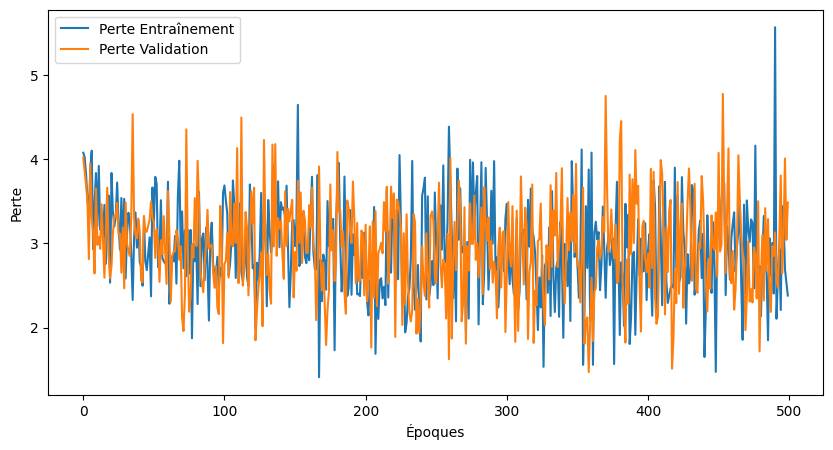

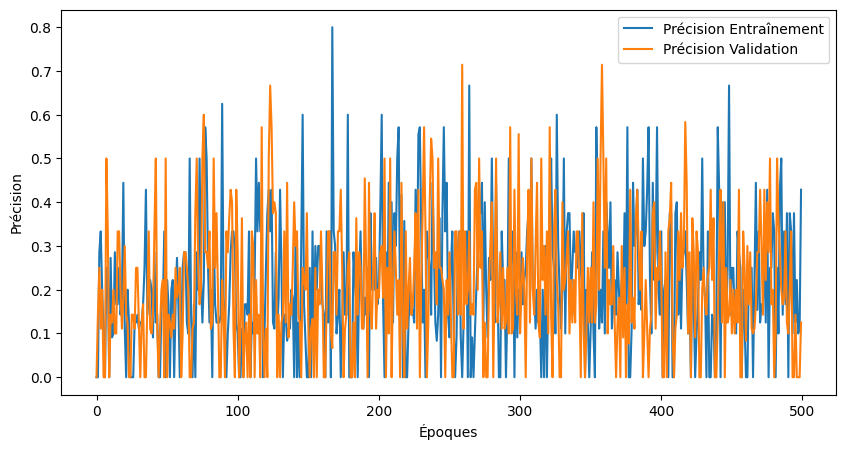


Époch 553 : La perte de validation a diminué à 1.2471. Modèle sauvegardé.
Précision validation : 0.7143

Prénoms générés :
- Aasha
- Batsov
- Catsov
- Datson
- Eatsov

Époch 888 : La perte de validation a diminué à 0.9807. Modèle sauvegardé.
Précision validation : 0.7500

Prénoms générés :
- Aalevichikov
- Balabininiichin
- Calovich
- Dalovich
- Eababininiich
0m 23.56s Époch 1000/1000, Perte entraînement : 4.3888, Précision entraînement : 0.0000
Perte validation : 2.8122, Précision validation : 0.2857


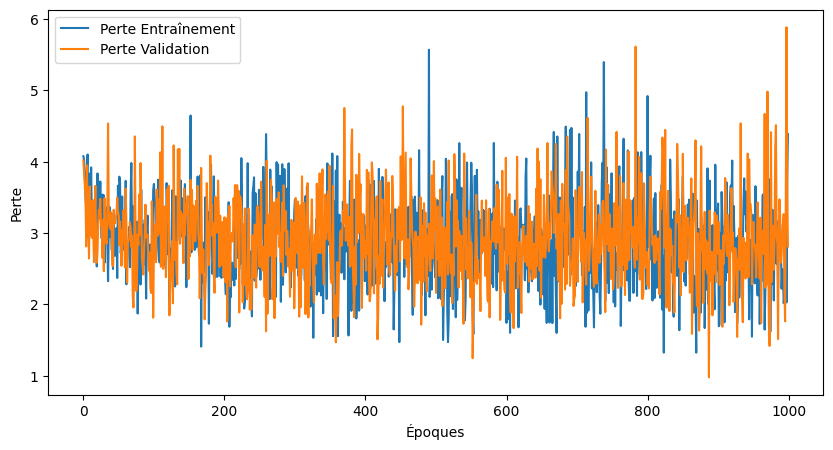

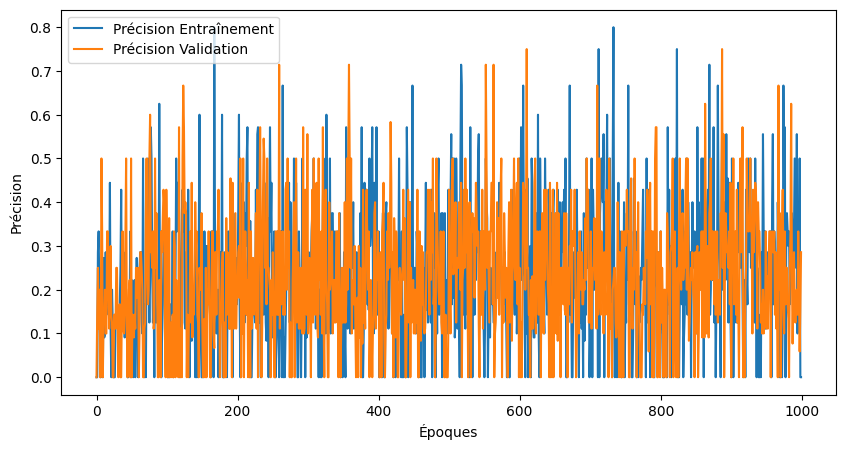


Chargement du meilleur modèle...

-----------
|  ÉVALUATION FINALE |
-----------

Perte moyenne sur l'ensemble de test : 2.5754
Précision moyenne sur l'ensemble de test : 0.2847

Prénoms générés avec le meilleur modèle :
- welovich
- Aalovich
- Yalovich
- Galovich
- Yalovich
- Aalovich
- rorovich
- ;alovich
- Kalovich
- chelnov
- lalrovich
- Qalovich
- lalrovich
- Yalovich
- dalrkininiich
- Calovich
- rorovich
- -alovich
- Halovich
- balrbininiichiko


In [4]:
import requests
import torch
import torch.nn as nn
from torch.autograd import Variable
import time
import math
import string
import random
import os
import matplotlib.pyplot as plt

# Vérification GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé : {device}")

# Téléchargement des données
url = "https://olivier-fabre.com/passwordgenius/russian.txt"
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
data_path = os.path.join(data_dir, "russian.txt")

if not os.path.exists(data_path):
    print("Téléchargement des données...")
    response = requests.get(url)
    with open(data_path, 'w', encoding='utf-8') as f:
        f.write(response.text)

# Chargement des données
def unicode_to_ascii(s):
    return ''.join(
        c for c in s if c in (string.ascii_letters + " .,;'-")
    )

def read_lines(filename):
    with open(filename, encoding='utf-8') as f:
        return [unicode_to_ascii(line.strip().lower()) for line in f]

lines = read_lines(data_path)
print(f"Nombre de prénoms : {len(lines)}")

# Division des données
random.shuffle(lines)
train_split = int(0.7 * len(lines))
valid_split = int(0.2 * len(lines))
train_lines = lines[:train_split]
valid_lines = lines[train_split:train_split + valid_split]
test_lines = lines[train_split + valid_split:]
print(f"Ensemble d'entraînement : {len(train_lines)}, Validation : {len(valid_lines)}, Test : {len(test_lines)}")

# Paramètres globaux
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # EOS marker
hidden_size = 256
n_layers = 3
lr = 0.003
bidirectional = True
max_length = 20
n_epochs = 1000

# Fonctions utilitaires
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_letters.index(string[c])
    return tensor

def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

def random_training_example(lines):
    line = random.choice(lines)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return input_line_tensor, target_line_tensor

# Fonction pour afficher le temps écoulé
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {s:.2f}s"

# Définition du modèle
class RNNLight(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNLight, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if self.bidirectional else 1
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=n_layers, bidirectional=self.bidirectional, batch_first=True
        )
        self.out = nn.Linear(self.num_directions * hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        _, hidden = self.rnn(input.unsqueeze(0), hidden)
        hidden_concat = hidden if not self.bidirectional else torch.cat((hidden[0], hidden[1]), 1)
        output = self.out(hidden_concat)
        output = self.dropout(output)
        return self.softmax(output), hidden

    def init_hidden(self):
        return torch.zeros(self.num_directions * n_layers, 1, self.hidden_size, device=device)

# Fonction pour générer des prénoms
def generate_prenoms(decoder, start_letters="ABCDE"):
    print("\nPrénoms générés :")
    for letter in start_letters:
        print(f"- {sample(decoder, letter)}")

def sample(decoder, start_letter="A"):
    with torch.no_grad():
        hidden = decoder.init_hidden()
        input = input_tensor(start_letter)
        output_name = start_letter
        for _ in range(max_length):
            output, hidden = decoder(input[0].to(device), hidden.to(device))
            topi = output.topk(1)[1][0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)
        return output_name

# Entraînement avec sauvegarde
def train(input_line_tensor, target_line_tensor, decoder, decoder_optimizer, criterion):
    target_line_tensor = target_line_tensor.to(device)
    hidden = decoder.init_hidden().to(device)
    decoder.zero_grad()
    loss = 0
    correct = 0  # Précision
    total = target_line_tensor.size(0)

    for i in range(input_line_tensor.size(0)):
        input_tensor = input_line_tensor[i].to(device)
        target_tensor = target_line_tensor[i].unsqueeze(0).to(device)
        output, hidden = decoder(input_tensor, hidden.detach())
        l = criterion(output, target_tensor)
        loss += l

        # Calcul de la précision
        predicted = output.topk(1)[1][0][0]
        correct += (predicted == target_tensor[0]).item()

    loss.backward()
    decoder_optimizer.step()

    accuracy = correct / total
    return loss.item() / input_line_tensor.size(0), accuracy

def validation(input_line_tensor, target_line_tensor, decoder, criterion):
    with torch.no_grad():
        target_line_tensor = target_line_tensor.to(device)
        hidden = decoder.init_hidden().to(device)
        loss = 0
        correct = 0
        total = target_line_tensor.size(0)

        for i in range(input_line_tensor.size(0)):
            input_tensor = input_line_tensor[i].to(device)
            target_tensor = target_line_tensor[i].unsqueeze(0).to(device)
            output, hidden = decoder(input_tensor, hidden.detach())
            l = criterion(output, target_tensor)
            loss += l

            # Calcul de la précision
            predicted = output.topk(1)[1][0][0]
            correct += (predicted == target_tensor[0]).item()

        accuracy = correct / total
        return loss.item() / input_line_tensor.size(0), accuracy

# Ajustement dynamique du taux d'apprentissage
def adjust_learning_rate(optimizer, epoch, decay_rate=0.5, step=20000):
    if epoch % step == 0 and epoch > 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= decay_rate
            print(f"Taux d'apprentissage ajusté à : {param_group['lr']}")

# Suivi des pertes et précisions
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Fonction principale d'entraînement
def training(n_epochs, train_lines, valid_lines, decoder, decoder_optimizer, criterion):
    print("\n-----------\n|  ENTRAÎNEMENT  |\n-----------\n")
    start = time.time()
    best_loss = float("inf")
    model_path = "best_model_generation_prenom.pth"

    for epoch in range(1, n_epochs + 1):
        adjust_learning_rate(decoder_optimizer, epoch)

        input_line_tensor, target_line_tensor = random_training_example(train_lines)
        train_loss, train_acc = train(input_line_tensor, target_line_tensor, decoder, decoder_optimizer, criterion)

        input_line_tensor, target_line_tensor = random_training_example(valid_lines)
        val_loss, val_acc = validation(input_line_tensor, target_line_tensor, decoder, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(decoder.state_dict(), model_path)
            print(f"\nÉpoch {epoch} : La perte de validation a diminué à {best_loss:.4f}. Modèle sauvegardé.")
            print(f"Précision validation : {val_acc:.4f}")
            generate_prenoms(decoder)

        if epoch % 500 == 0 or epoch == 1:
            print(f"{time_since(start)} Époch {epoch}/{n_epochs}, Perte entraînement : {train_loss:.4f}, Précision entraînement : {train_acc:.4f}")
            print(f"Perte validation : {val_loss:.4f}, Précision validation : {val_acc:.4f}")

            # Afficher les graphiques interactifs
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Perte Entraînement')
            plt.plot(val_losses, label='Perte Validation')
            plt.legend()
            plt.xlabel('Époques')
            plt.ylabel('Perte')
            plt.show()

            plt.figure(figsize=(10, 5))
            plt.plot(train_accuracies, label='Précision Entraînement')
            plt.plot(val_accuracies, label='Précision Validation')
            plt.legend()
            plt.xlabel('Époques')
            plt.ylabel('Précision')
            plt.show()

# Évaluation finale
def evaluate_model(test_lines, decoder, criterion):
    print("\n-----------\n|  ÉVALUATION FINALE |\n-----------\n")
    total_loss = 0
    total_correct = 0
    total_samples = 0
    decoder.eval()

    with torch.no_grad():
        for line in test_lines:
            input_line_tensor = input_tensor(line)
            target_line_tensor = target_tensor(line)
            loss, acc = validation(input_line_tensor, target_line_tensor, decoder, criterion)
            total_loss += loss
            total_correct += acc * len(line)
            total_samples += len(line)

    avg_loss = total_loss / len(test_lines)
    avg_accuracy = total_correct / total_samples
    print(f"Perte moyenne sur l'ensemble de test : {avg_loss:.4f}")
    print(f"Précision moyenne sur l'ensemble de test : {avg_accuracy:.4f}")

    # Génération de 20 prénoms avec le meilleur modèle
    print("\nPrénoms générés avec le meilleur modèle :")
    for _ in range(20):
        start_letter = random.choice(all_letters)  # Démarrer avec une lettre aléatoire
        print(f"- {sample(decoder, start_letter)}")


# Exécution principale
if __name__ == "__main__":
    decoder = RNNLight(n_letters, hidden_size, n_letters).to(device)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    print("Démarrage de l'entraînement...")
    training(n_epochs, train_lines, valid_lines, decoder, decoder_optimizer, criterion)

    print("\nChargement du meilleur modèle...")
    # Chargement sécurisé pour éviter tout code malveillant
    state_dict = torch.load("best_model_generation_prenom.pth", map_location=device, weights_only=True)
    decoder.load_state_dict(state_dict)
    evaluate_model(test_lines, decoder, criterion)